In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchtext
import torchaudio
from torchaudio import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

import os
from joblib import Parallel, delayed
from tqdm import tqdm

In [ ]:
!pip install pydub

# GSCv2 12

In [ ]:
train_dataset = tfds.load('speech_commands', split = 'train')
val_dataset = tfds.load('speech_commands', split = 'validation')
test_dataset = tfds.load('speech_commands', split = 'test')

In [ ]:
import pandas as pd

def TF_GSC_metadata(dataset, output_directory, num_classes = 12,
                       mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }
    for i in range(num_classes):
        if not os.path.exists(os.path.join(output_directory, f'label_{i}')):
            os.mkdir(os.path.join(output_directory, f'label_{i}'))
    for idx in range(mul_factor):
        # def f(ix, ex):
        for ix, ex in tqdm(enumerate(dataset), desc = 'Processing...'):
            label = ex['label'].numpy()

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            #row = {
            #    'link': os.path.join(output_directory, f'label_{label}', fname),
            #    'label': label,
            #    'set': set
            #}
            out_df['link'].append(os.path.join(set, fname))
            out_df['label'].append(label)

            if os.path.exists(os.path.join(output_directory, f'label_{label}', fname)):
                continue

            wav = ex['audio']
            wav = soundDataToFloat(wav.numpy())

            #out_df = out_df._append(row, ignore_index = True)
            np.savez_compressed(os.path.join(output_directory, f'label_{label}', fname), wav)

        # Parallel(n_jobs = os.cpu_count())(delayed(f)(i, ex) for i, ex in tqdm(enumerate(dataset)))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

# GSCv2_35

In [2]:
train_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'training')
val_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'validation')
test_dataset_pt = datasets.SPEECHCOMMANDS('./', 'speech_commands_v0.02', download = True, subset = 'testing')

100%|██████████| 2.26G/2.26G [00:44<00:00, 54.4MB/s]


In [ ]:
import IPython.display as ipd

wav, sr, label, *_ = train_dataset_pt[0]
print(label)
ipd.Audio(wav, rate = sr)

backward


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


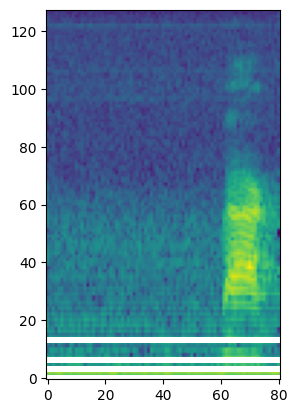

In [ ]:
mel = torchaudio.transforms.MelSpectrogram()
spec = mel(wav)
plt.imshow(spec.squeeze(0).log(), origin = 'lower')

In [3]:
labels = ['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']
len(labels)

35

# Data Augmentation

In [ ]:
a = torch.Tensor(1,2)

In [18]:
import random

def pad_truncate(wav, max_length = 16000, pad_value = 0):
    wav_length = len(wav)
    if wav_length < max_length:
        pad = torchtext.transforms.PadTransform(max_length, 0)
        wav = pad(wav)
    return wav

def time_shift(wav, shift, sr = 16000, max_length = 16000):
    """

    shift: float
        Unit: Seconds
    """
    wav = torch.roll(wav, int(shift*sr))
    return wav[:, :max_length]

## Add Noise

def normalzieNoise(wav, noise, max_length = 16000):
    len_wav = wav.shape[1]
    len_noise = noise.shape[1]
    if len_wav > len_noise:
        buf = torch.zeros_like(wav)
        start_point = int((len_wav - len_noise)*random.uniform(0, 1))
        end_point = start_point + len_noise
        buf[:, start_point: end_point] = noise
        noise = buf
    elif len_wav < len_noise:
        start_point = int((len_noise - len_wav)*random.uniform(0, 1))
        end_point = start_point + len_wav
        noise = noise[:, start_point: end_point]
    return noise[:, :max_length]

def randomNoise(noise_directory):
    listnoise = [f for f in os.listdir(noise_directory)
                 if f.endswith('.wav')]
    noise = random.choice(listnoise)
    noise, sr = torchaudio.load(os.path.join(noise_directory, noise))
    return noise

def addNoise(wav, noise):
    noise = normalzieNoise(wav, noise)
    addnsy = torchaudio.transforms.AddNoise()
    return addnsy(wav, noise, snr = torch.Tensor([random.uniform(0, 15)]))

class AddBGNoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.NOISE_PATH = '/content/SpeechCommands/speech_commands_v0.02/_background_noise_'

    def forward(self, x):
        p = random.uniform(0, 1)
        if p <= 0.9:
            noise = randomNoise(self.NOISE_PATH)
            x = addNoise(x, noise)
        return x

class GSC_TrainAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        self.resample = torchaudio.transforms.Resample(sr, int(sr*random.uniform(0.9, 1.1)))
        self.time_shift = lambda x: time_shift(x, random.uniform(-0.05, 0.05))
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        self.add_noise = AddBGNoise()
        self.mel = torchaudio.transforms.MelSpectrogram(sr, n_mels = 40)
        self.specaugment = torchaudio.transforms.SpecAugment(n_time_masks = 2,
                                      time_mask_param = random.randint(0, 10),
                                      n_freq_masks = 2,
                                      freq_mask_param = random.randint(0, 10))
    def forward(self, x):
        x = self.resample(x)
        x = self.time_shift(x)
        x = self.pad_trunc(x)
        x = self.add_noise(x)
        x = self.mel(x)
        x = self.specaugment(x)
        return x

class GSC_TestAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        self.mel = torchaudio.transforms.MelSpectrogram(sr, n_mels = 40)

    def forward(self, x):
        x = self.pad_trunc(x)
        x = self.mel(x)
        return x

train_transform = GSC_TrainAugment(16000)
test_transform = GSC_TestAugment(16000)

In [ ]:
train_transform(torch.Tensor(1, 18000)).shape

torch.Size([1, 16000])
torch.Size([1, 16000])


torch.Size([1, 40, 81])

## BC-ResNet

In [12]:
import random

def pad_truncate(wav, max_length = 16000, pad_value = 0):
    wav_length = len(wav)
    if wav_length < max_length:
        pad = torchtext.transforms.PadTransform(max_length, 0)
        wav = pad(wav)
    return wav

def time_shift(wav, shift, sr = 16000, max_length = 16000):
    """

    shift: float
        Unit: Seconds
    """
    wav = torch.roll(wav, int(shift*sr))
    return wav[:, :max_length]

## Add Noise

def normalzieNoise(wav, noise, max_length = 16000):
    len_wav = wav.shape[1]
    len_noise = noise.shape[1]
    if len_wav > len_noise:
        buf = torch.zeros_like(wav)
        start_point = int((len_wav - len_noise)*random.uniform(0, 1))
        end_point = start_point + len_noise
        buf[:, start_point: end_point] = noise
        noise = buf
    elif len_wav < len_noise:
        start_point = int((len_noise - len_wav)*random.uniform(0, 1))
        end_point = start_point + len_wav
        noise = noise[:, start_point: end_point]
    return noise[:, :max_length]

def randomNoise(noise_directory):
    listnoise = [f for f in os.listdir(noise_directory)
                 if f.endswith('.wav')]
    noise = random.choice(listnoise)
    noise, sr = torchaudio.load(os.path.join(noise_directory, noise))
    return noise

def addNoise(wav, noise):
    noise = normalzieNoise(wav, noise)
    addnsy = torchaudio.transforms.AddNoise()
    return addnsy(wav, noise, snr = torch.Tensor([random.uniform(0, 15)]))

class AddBGNoise(nn.Module):
    def __init__(self):
        super().__init__()
        self.NOISE_PATH = '/content/SpeechCommands/speech_commands_v0.02/_background_noise_'

    def forward(self, x):
        p = random.uniform(0, 1)
        if p <= 0.8:
            noise = randomNoise(self.NOISE_PATH)
            x = addNoise(x, noise)
        return x

class GSC_TrainAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        #self.resample = torchaudio.transforms.Resample(sr, int(sr*random.uniform(0.85, 1.15)))
        self.time_shift = lambda x: time_shift(x, random.uniform(-0.1, 0.1))
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        self.add_noise = AddBGNoise()
        self.mel = torchaudio.transforms.MelSpectrogram(sr, n_mels = 40,
                                                        win_length=480,
                                                        n_fft = 480,
                                                        hop_length = 160)
        self.specaugment = torchaudio.transforms.SpecAugment(n_time_masks = 2,
                                      time_mask_param = 20,
                                      n_freq_masks = 2,
                                      freq_mask_param = 7)
    def forward(self, x):
        #x = self.resample(x)
        x = self.time_shift(x)
        x = self.pad_trunc(x)
        x = self.add_noise(x)
        x = self.mel(x)
        x = self.specaugment(x)
        return x

class GSC_TestAugment(nn.Module):
    def __init__(self, sr):
        super().__init__()
        self.pad_trunc = lambda x: pad_truncate(x, sr)
        self.mel = torchaudio.transforms.MelSpectrogram(sr, n_mels = 40,
                                                        win_length = 480,
                                                        n_fft = 480,
                                                        hop_length = 160)

    def forward(self, x):
        x = self.pad_trunc(x)
        x = self.mel(x)
        return x

train_transform = GSC_TrainAugment(16000)
test_transform = GSC_TestAugment(16000)

# Preprocessing

In [ ]:
TRAIN_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12/train'
VAL_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12/val'
TEST_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12/test'

TRAIN_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35/train'
VAL_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35/val'
TEST_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35/test'

In [ ]:
TRAIN_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/train'
VAL_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/val'
TEST_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/test'

TRAIN_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_np/train'
VAL_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_np/val'
TEST_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_np/test'

## BC ResNet

In [5]:
TRAIN_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_BC_Resnet/train'
VAL_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_BC_Resnet/val'
TEST_GSC_12_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_BC_Resnet/test'

TRAIN_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_BC_Resnet/train'
VAL_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_BC_Resnet/val'
TEST_GSC_35_DIR = '/content/drive/MyDrive/GSC/Background_Noise/GSC_35_BC_Resnet/test'

## 12 labels

In [ ]:
import pandas as pd

def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32((s>>2)/(32768.0)) for s in SD])

def GSC_preprocessing(dataset, output_directory, num_classes = 12, transform = None,
                       mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }
    for i in range(num_classes):
        if not os.path.exists(os.path.join(output_directory, f'label_{i}')):
            os.mkdir(os.path.join(output_directory, f'label_{i}'))
    for idx in range(mul_factor):
        def f(ix, ex):
        # for ix, ex in tqdm(enumerate(dataset), desc = 'Processing...'):
            wav = ex['audio']
            wav = soundDataToFloat(wav.numpy())
            label = ex['label'].numpy()

            wav = torch.from_numpy(wav).unsqueeze(0)

            if transform:
                wav = transform(wav.float())

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            #row = {
            #    'link': os.path.join(output_directory, f'label_{label}', fname),
            #    'label': label,
            #    'set': set
            #}
            out_df['link'].append(os.path.join(output_directory, f'label_{label}', fname))
            out_df['label'].append(label)
            #out_df = out_df._append(row, ignore_index = True)
            np.savez_compressed(os.path.join(output_directory, f'label_{label}', fname), wav.squeeze(0).numpy())

        Parallel(n_jobs = os.cpu_count())(delayed(f)(i, ex) for i, ex in tqdm(enumerate(dataset)))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

In [ ]:
GSC_preprocessing(train_dataset, TRAIN_GSC_12_DIR, train_transform, csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12/train.csv')

Processing...: 85511it [2:47:11,  8.52it/s]


In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/GSC/Background_Noise/GSC_12/train.csv')
train_csv.head()

,link,label,set
0,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(4, shape=(), dtype=int64)",train
1,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(5, shape=(), dtype=int64)",train
2,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(7, shape=(), dtype=int64)",train
3,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(5, shape=(), dtype=int64)",train
4,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(7, shape=(), dtype=int64)",train


In [ ]:
spec = torch.load(train_csv.iloc[0]['link'])

In [ ]:
spec.shape

torch.Size([1, 40, 81])

In [ ]:
GSC_preprocessing(val_dataset, VAL_GSC_12_DIR, transform = test_transform, set = 'val', csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/val.csv')

In [ ]:
val_csv = pd.read_csv('/content/drive/MyDrive/GSC/Background_Noise/GSC_12/val.csv')
val_csv.head()

,link,label,set
0,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(3, shape=(), dtype=int64)",val
1,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(11, shape=(), dtype=int64)",val
2,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(10, shape=(), dtype=int64)",val
3,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(11, shape=(), dtype=int64)",val
4,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(11, shape=(), dtype=int64)",val


In [ ]:
GSC_preprocessing(test_dataset, TEST_GSC_12_DIR, transform = test_transform, set = 'test', csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/test.csv')

In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/GSC/Background_Noise/GSC_12/test.csv')
test_csv.head()

,link,label,set
0,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(7, shape=(), dtype=int64)",train
1,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(2, shape=(), dtype=int64)",train
2,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(6, shape=(), dtype=int64)",train
3,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(8, shape=(), dtype=int64)",train
4,/content/drive/MyDrive/GSC/Background_Noise/GS...,"tf.Tensor(5, shape=(), dtype=int64)",train


## 35 labels

In [ ]:
import pandas as pd

def GSC_preprocessing(dataset, output_directory, num_classes=35, transform = None, warm_up = 0,
                       mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }


    for idx in range(mul_factor):
        def f(ix, wav, label):
        #for ix, (wav, _, label, *_) in tqdm(enumerate(dataset), desc = 'Processing...'):
            #if ix < warm_up:
            #    continue
            label = labels.index(label)
            #wav = torch.from_numpy(wav).unsqueeze(0)

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            out_df['link'].append(os.path.join(output_directory, fname))
            out_df['label'].append(label)

            if ix>= warm_up:
                if transform:
                    wav = transform(wav)
                np.savez_compressed(os.path.join(output_directory, fname), wav.squeeze(0).numpy())

        Parallel(n_jobs = os.cpu_count())(delayed(f)(i, wav, label) for i, (wav, _, label, *_) in enumerate(dataset))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

In [6]:
import pandas as pd

def GSC_preprocessing(dataset, output_directory, num_classes=35, transform = None, warm_up = 0,
                       mul_factor = 1, set = 'train', csv_file_name = 'analysised_spec.csv'):
    """
    Preprocessing for each dataset

    mul_factor: increasing the number of data samples by mul_factor times.
    """
    out_df = {
        'link': [],
        'label': [],
    }

    for idx in range(mul_factor):
        #def f(ix, wav, label):
        for ix, (wav, _, label, *_) in tqdm(enumerate(dataset), desc = 'Processing...'):
            #if ix < warm_up:
            #    continue
            label = labels.index(label)
            #wav = torch.from_numpy(wav).unsqueeze(0)

            fname = f'{set}_{label}_{ix}_{idx}.npz'
            out_df['link'].append(os.path.join(set, fname))
            out_df['label'].append(label)
            if os.path.exists(os.path.join(output_directory, fname)):
                continue

            if ix>= warm_up:
                if transform:
                    wav = transform(wav)
                np.savez_compressed(os.path.join(output_directory, fname), wav.squeeze(0).numpy())

        #Parallel(n_jobs = os.cpu_count())(delayed(f)(i, wav, label) for i, (wav, _, label, *_) in enumerate(dataset))

    out_df = pd.DataFrame(out_df)
    out_df.to_csv(csv_file_name, index = False)

In [24]:
GSC_preprocessing(train_dataset_pt, '/content/train_3', transform = train_transform, set = 'train', csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/train_35.csv')

Processing...: 84843it [1:03:03, 22.42it/s]


In [20]:
GSC_preprocessing(val_dataset_pt, '/content/val_3', transform = test_transform, set = 'val', csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/val_35.csv')

Processing...: 9981it [00:51, 192.91it/s]


In [21]:
GSC_preprocessing(test_dataset_pt, '/content/test_3', transform = test_transform, set = 'test', csv_file_name = '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/test_35.csv')

Processing...: 11005it [01:19, 139.04it/s]


In [9]:
import sys

sys.path.append('/content/drive/MyDrive/GSC/GSC_helper')
from GSC_zip import zipzip, unzipzip

In [22]:
zipzip('/content/test_3', '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/test_35.zip')

zipping...: 100%|██████████| 11005/11005 [00:09<00:00, 1133.02it/s]


/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/test_35.zip created


In [23]:
zipzip('/content/val_3', '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/val_35.zip')

zipping...: 100%|██████████| 9981/9981 [00:06<00:00, 1598.01it/s]


/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/val_35.zip created


In [25]:
zipzip('/content/train_3', '/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/train_35.zip')

zipping...: 100%|██████████| 84843/84843 [01:21<00:00, 1045.62it/s]


/content/drive/MyDrive/GSC/Background_Noise/GSC_12_np/train_35.zip created
